In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
def compute_posteriors(X, pi, mu, sigma):
    
    N = X.shape[0]
    D = X.shape[1]
    K = pi.shape[0]
    
    posteriors = np.zeros((X.shape[0], pi.shape[0]))
    
    for i in range(X.shape[0]):
        
        x = X[i,:]

        assert x.shape == (D,)
        assert pi.shape == (K,)
        assert mu.shape == (K,D)
        assert sigma.shape == (K,D,D)
        
        # inside the exponential
        in_exp = -.5*np.matmul((x-mu).reshape(K,1,D), np.matmul(np.linalg.inv(sigma), (x-mu).reshape(K,D,1))).reshape(-1)
        # outside of the exponential
        out_exp = pi*(1/(2*np.pi)/np.linalg.det(sigma))**.5
        # term-wise product
        posterior = out_exp*np.exp(in_exp)
        # divide by the sum of gammas
        posterior /= np.sum(posterior)
        
        posteriors[i] = posterior
    
    return posteriors

In [3]:
def initialize_parameters(X, method, K=None):
    
    if method == 'PRML':
        
        mu = np.array([[-1.4, 1], [1.4, -1]])
        sigma = np.concatenate([.8*np.eye(2).reshape(1,2,2) for i in range(2)], axis=0)
        pi_1 = np.mean(np.argmin(np.linalg.norm(X.reshape(272,2,1) - mu.T.reshape(1,2,2), axis=1), axis=1), axis=0)
        pi = np.array([1-pi_1, pi_1])
    
    elif method == 'kmeans':
        
        assert K is not None
        
        kmeans = KMeans(n_clusters=K)
        kmeans.fit(X)

        z = kmeans.labels_
        z_cat = np.eye(3)[z]
        
        pi = np.sum(z_cat[:,:K], axis=0)/X.shape[0]
        mu = kmeans.cluster_centers_
        # Caution: this is not right, we should estimate the covariance matrix based on the clusters
        sigma = np.concatenate([np.eye(2).reshape(1,2,2) for i in range(K)], axis=0)
    
    else:
        raise Error('No valid method specified.')
    
    return pi, mu, sigma

In [4]:
def update_parameters(X, gammas):
    
    mu_new = np.matmul(gammas.T, X) / np.sum(gammas, axis=0).reshape(gammas.shape[1],1)
    
    X = X.copy().reshape(X.shape[0], X.shape[1], 1)
    sigma_new = np.zeros((gammas.shape[1],2,2))
    for k in range(gammas.shape[1]):
        sigma_new[k] = np.sum(gammas[:,k].reshape(-1,1,1) * np.matmul(X-mu_new[k].reshape(2,1), (X-mu_new[k].reshape(2,1)).reshape(X.shape[0],1,2)), axis=0) / np.sum(gammas[:,k])
    
    pi_new = np.sum(gammas, axis=0)/X.shape[0]
    
    return pi_new, mu_new, sigma_new 

In [5]:
def plot_step(X, gammas, mu, sigma):
    
    if gammas.shape[1] < 3:
        gammas = np.concatenate((gammas, np.zeros((X.shape[0], 1))), axis=1)
        
    ell_0 = np.array([mu[0] + np.matmul(sigma[0], np.array([np.cos(theta), np.sin(theta)])) for theta in np.linspace(0, 2*np.pi, 1000)])
    ell_1 = np.array([mu[1] + np.matmul(sigma[1], np.array([np.cos(theta), np.sin(theta)])) for theta in np.linspace(0, 2*np.pi, 1000)])
    if mu.shape[0] == 3:
        ell_2 = np.array([mu[2] + np.matmul(sigma[2], np.array([np.cos(theta), np.sin(theta)])) for theta in np.linspace(0, 2*np.pi, 1000)])
    
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=gammas)
    plt.scatter(mu[:,0], mu[:,1], marker='X', s=100)
    plt.scatter(ell_0[:,0], ell_0[:,1], color='black', s=.1)
    plt.scatter(ell_1[:,0], ell_1[:,1], color='black', s=.1)
    if mu.shape[0] == 3:
        plt.scatter(ell_2[:,0], ell_2[:,1], color='black', s=.1)
    # plt.xlim(-4,4)
    # plt.ylim(-2,2)
    plt.show()  

In [6]:
def compute_ll(X, pi, mu, sigma):

    N, K, D = X.shape[0], pi.shape[0], X.shape[1]

    ll = 0
    for i in range(X.shape[0]):

        x = X[i,:]

        assert x.shape == (D,)
        assert pi.shape == (K,)
        assert mu.shape == (K,D)
        assert sigma.shape == (K,D,D)

        # inside the exponential
        in_exp = -.5*np.matmul((x-mu).reshape(K,1,D), np.matmul(np.linalg.inv(sigma), (x-mu).reshape(K,D,1))).reshape(-1)
        # outside of the exponential
        out_exp = pi*(1/(2*np.pi)/np.linalg.det(sigma))**.5
        # term-wise product
        posterior = out_exp*np.exp(in_exp)
        # sum over k
        in_log = np.sum(posterior)
        # pass it log and sum over n
        ll += np.log(in_log)

    return ll

In [7]:
def em(X, init_method, max_iter, threshold, K=None):
    
    pi, mu, sigma = initialize_parameters(X, method=init_method, K=K)
    gammas = compute_posteriors(X, pi, mu, sigma)
    plot_step(X, gammas, mu, sigma)
    
    ll_hist = [compute_ll(X, pi, mu, sigma)]
    
    c = 0
    while c < max_iter and (c<2 or ll_hist[-1]-ll_hist[-2] > threshold):
        pi, mu, sigma = update_parameters(X, gammas)
        ll_hist.append(compute_ll(X, pi, mu, sigma))
        plot_step(X, gammas, mu, sigma)
        gammas = compute_posteriors(X, pi, mu, sigma)
        c += 1
        
    print(f'{c+1} iterations done.')
        
    return pi, mu, sigma, ll_hist

In [8]:
data = pd.read_csv('./old_faithful.tsv', sep='\t')

In [11]:
%matplotlib inline


/var/folders/9y/2_bwn53x4jn9ty7q2y7q9b0w0000gn/T/ipykernel_68009/3796398193.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


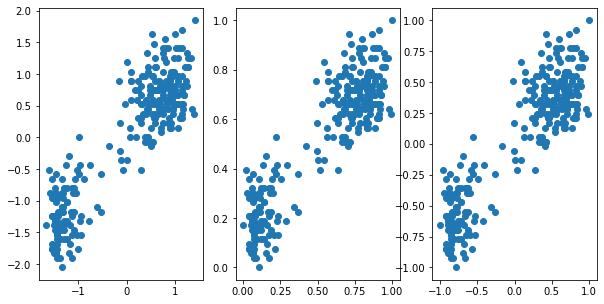

In [19]:
fig, axs = plt.subplot_mosaic("""ABC""", figsize=(10,5))

axs["A"].scatter(data_moy_std.eruptions, data_moy_std.waiting)
axs["B"].scatter(data_minmax_01.eruptions, data_minmax_01.waiting)
axs["C"].scatter(data_minmax_11.eruptions, data_minmax_11.waiting)

fig.show()

/var/folders/9y/2_bwn53x4jn9ty7q2y7q9b0w0000gn/T/ipykernel_68009/323858235.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/9y/2_bwn53x4jn9ty7q2y7q9b0w0000gn/T/ipykernel_68009/323858235.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


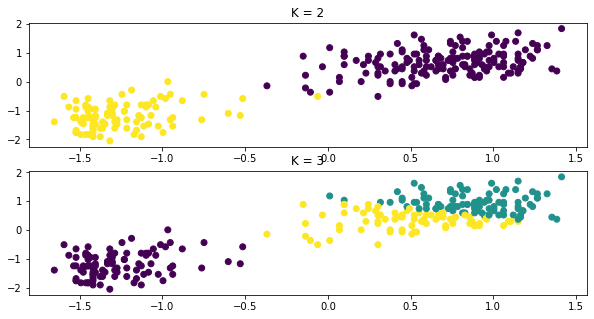

In [30]:
from sklearn.cluster import KMeans

K = [2,3]

fig, axs = plt.subplots(2, 1, figsize=(10,5))


for k, ax in zip(K, axs.flatten()):
    clf = KMeans(n_clusters=k)
    classes = clf.fit_predict(data_moy_std)
    
    ax.scatter(data_moy_std.eruptions, data_moy_std.waiting, c=classes)
    ax.set_title(f"K = {k}")
    fig.show()

In [17]:
classes

array([2, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1,
       2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       2, 2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 0, 1, 0,
       2, 0, 1, 2, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0,
       1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 2,
       2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 1, 0,
       2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0,
       2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2,
       1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2,
       1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1, 2, 1,
       0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 0, 1, 0,
       1, 1, 2, 0, 1, 0, 1, 2], dtype=int32)